In [1]:
import numpy as np
import torch
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
from diffusers import StableDiffusionInpaintPipeline,DPMSolverMultistepScheduler

device = 'cuda' if torch.cuda.is_available() else 'cpu'


c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
c:\Users\User\miniconda3\envs\torch_env\lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


In [2]:
model_id = 'stable-diffusion-v1-5/stable-diffusion-v1-5'


inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, 
                                                              torch_dtype=torch.float16, 
                                                              device_map=device)

inpaint_pipe.scheduler = DPMSolverMultistepScheduler.from_config(inpaint_pipe.scheduler.config, algorithm_type="sde-dpmsolver++")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# Segment The object using SAM

In [ ]:
from transformers import Sam2Processor, Sam2Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam2Model.from_pretrained("facebook/sam2.1-hiera-small").to(device)
processor = Sam2Processor.from_pretrained("facebook/sam2.1-hiera-small")

You are using a model of type sam2_video to instantiate a model of type sam2. This is not supported for all configurations of models and can yield errors.


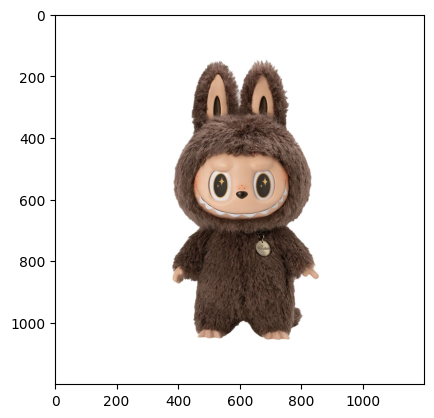

In [8]:
raw_image = Image.open('labubu.webp').convert("RGB")
plt.imshow(raw_image)
plt.show()

In [37]:


input_boxes = [[[300, 100, 900,1100]]]  # Single point click, 4 dimensions (image_dim, object_dim, point_per_object_dim, coordinates)

inputs = processor(images=raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"])[0]
mask = masks[0,outputs.iou_scores.argmax().item()].cpu().numpy()
# The model outputs multiple mask predictions ranked by quality score
print(f"Generated {masks.shape[1]} masks with shape {masks.shape}")

Generated 3 masks with shape torch.Size([1, 3, 1200, 1200])


## Inpainting Pipeline

In [3]:
from transformers import pipeline

generator = pipeline("mask-generation", model="facebook/sam2.1-hiera-small", device=0)
image_url = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/truck.jpg"
outputs = generator(image_url, points_per_batch=64)

len(outputs["masks"])  # Number of masks generated

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/184M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

Device set to use cuda:0


39

In [4]:
ref_image = Image.open(r'labubu.webp')
with torch.no_grad():
    outputs = generator(ref_image, points_per_batch=2)

In [6]:
outputs

{'masks': [tensor([[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]),
  tensor([[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]),
  tensor([[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., Fals

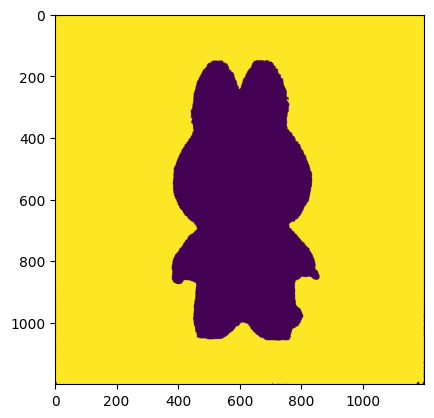

In [5]:
plt.imshow(outputs['masks'][0])

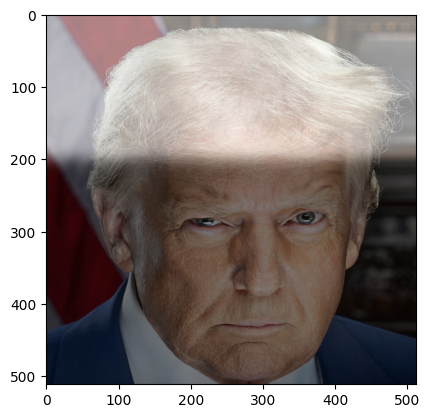

In [13]:
from scipy.ndimage import gaussian_filter

ref_image = Image.open('dt.png').crop((300,200,2200,2300)).resize((512,512)).convert('RGB')

mask = np.zeros((512,512), dtype=np.float32)
mask[0:200, :] = 1.0
mask = gaussian_filter(mask, sigma=10)
mask=Image.fromarray((mask * 255).astype(np.uint8))

# plot the mask and inv mask
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

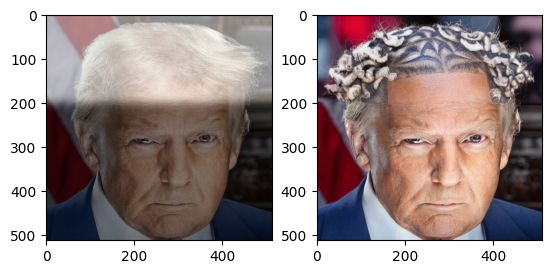

In [23]:
gen_image = inpaint_pipe(prompt="black dark hair, jay z",
                            image=ref_image, 
                            mask_image=mask,
                            strength=0.6, 
                            guidance_scale=7.5, 
                            num_inference_steps=50,
                            ).images[0]

plt.subplot(1,2,1)
plt.imshow(ref_image)
plt.imshow(mask,cmap='grey',alpha=0.5)
plt.subplot(1,2,2)
plt.imshow(gen_image)
# clear_output(wait=True)
plt.show()